In [1]:
!pip install --upgrade pip
!pip install opencv-python
!pip install torch

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\moham\anaconda3\python.exe -m pip install --upgrade pip


In [2]:
import torch
print(torch.cuda.is_available())  # Should print True


False


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier  # CPU-based RF
from sklearn.tree import DecisionTreeClassifier  # CPU-based DT
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
DATASET_PATH = ".\\Dataset\\MangoLeafBD Dataset"  # Change this to your dataset path
classes = os.listdir(DATASET_PATH)
print("Classes:", classes)

Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [4]:
# Data preprocessing & Feature Extraction (HOG)
def load_data(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
                images.append(hog_features)
                labels.append(class_name)
    
    return np.array(images), np.array(labels)  

In [5]:
# Load and preprocess the data
X, y = load_data(DATASET_PATH)
print("Data Loaded Successfully!")

Data Loaded Successfully!


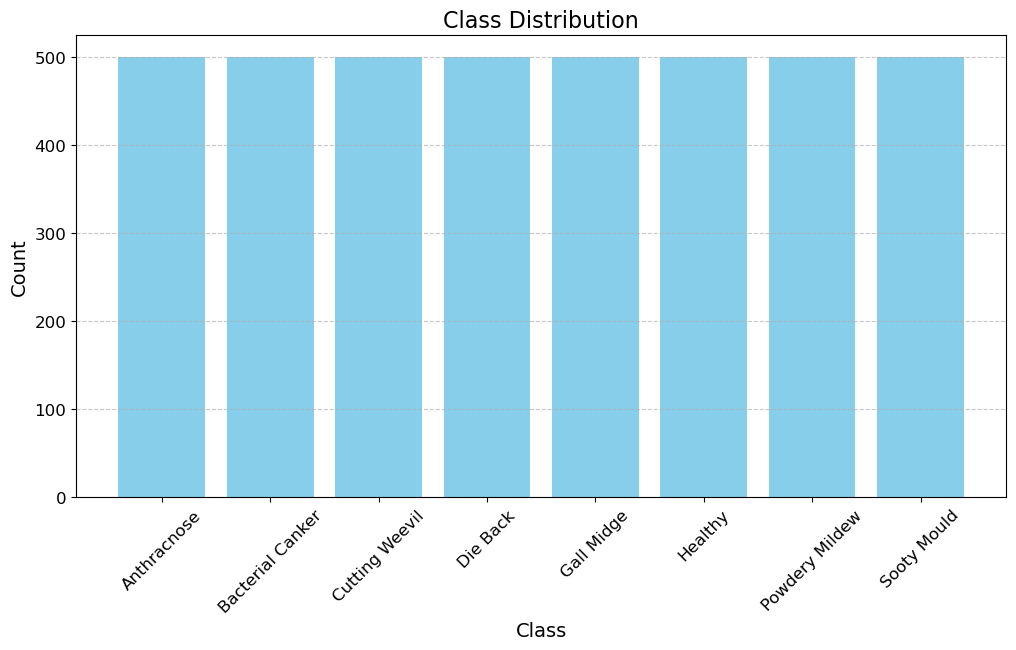

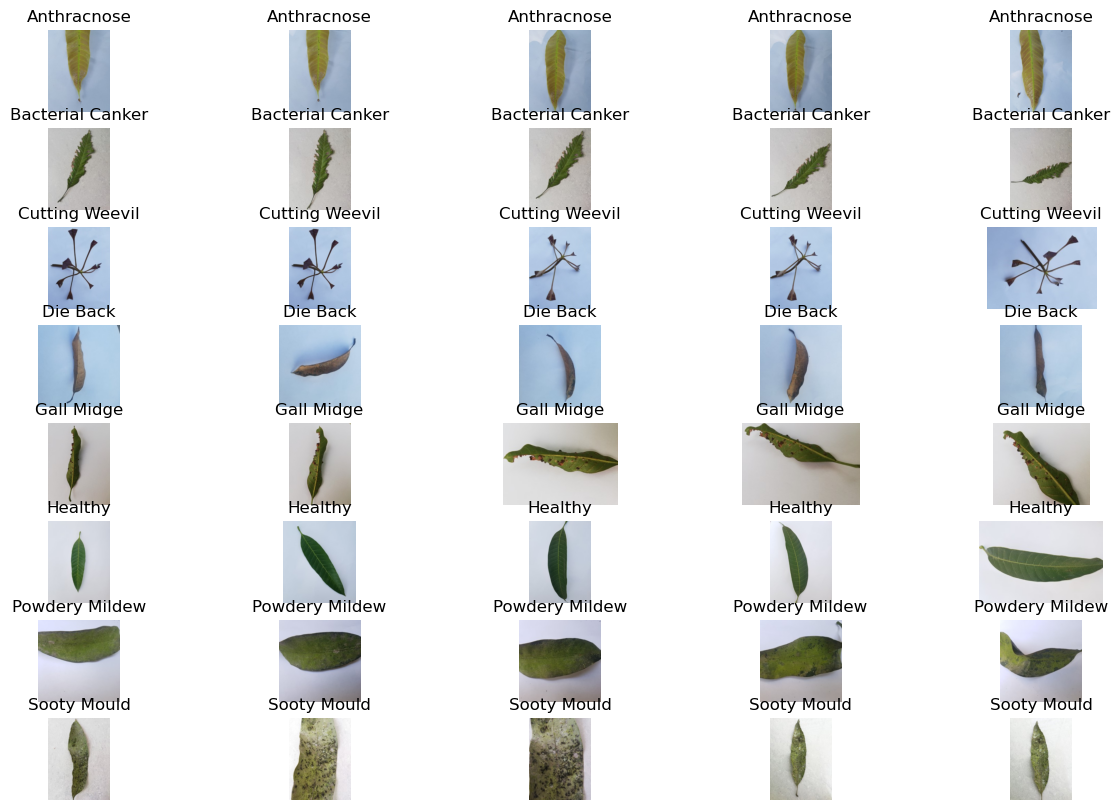

In [6]:
# EDA: Visualize class distribution
label_encoder = LabelEncoder()
label_encoder.fit(y)  # Fit the label encoder with the class labels
encoded_labels = label_encoder.transform(y)
class_counts = pd.Series(encoded_labels).value_counts()
class_names = label_encoder.inverse_transform(class_counts.index)

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# EDA: Display some sample images
def display_sample_images(dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        img_names = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
            
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
    plt.show()

display_sample_images(DATASET_PATH, classes)

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,     # Random rotation between -20 to +20 degrees
    width_shift_range=0.2, # Random horizontal shift
    height_shift_range=0.2,# Random vertical shift
    horizontal_flip=True,  # Random horizontal flips
    zoom_range=0.2,       # Random zoom
    fill_mode='nearest'   # Strategy for filling new pixels
)

def augment_dataset(X_train, y_train, samples_per_image=5):
    """
    Augments the dataset by generating multiple variations of each image
    
    Parameters:
    X_train: Original training images
    y_train: Original training labels
    samples_per_image: Number of augmented samples to generate per original image
    
    Returns:
    X_augmented, y_augmented: Augmented images and corresponding labels
    """
    X_augmented = []
    y_augmented = []
    
    for i in range(len(X_train)):
        # Reshape image to (1, height, width, channels)
        img = X_train[i].reshape((1,) + X_train[i].shape)
        
        # Generate augmented images
        j = 0
        for batch in datagen.flow(img, batch_size=1):
            X_augmented.append(batch[0])
            y_augmented.append(y_train[i])
            j += 1
            if j >= samples_per_image:
                break
                
    return np.array(X_augmented), np.array(y_augmented)


In [20]:
# Reshape HOG features to have a rank of 4
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, 1, X_train.shape[1]))
X_augmented, y_augmented = augment_dataset(X_train_reshaped, y_train, samples_per_image=5)

c:\Users\moham\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 1, 1, 1764) (1764 channels).
  warnings.warn(


In [21]:
# Reshape the augmented data to 2D
X_augmented_reshaped = X_augmented.reshape(X_augmented.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [22]:



# Train Decision Tree Model using augmented data
dt_model = DecisionTreeClassifier()
dt_model.fit(X_augmented_reshaped, y_augmented)
y_pred_dt = dt_model.predict(X_test_reshaped)



# # Reshape the data to 2D
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Train Decision Tree Model
# dt_model = DecisionTreeClassifier()
# dt_model.fit(X_train_reshaped, y_train)
# y_pred_dt = dt_model.predict(X_test_reshaped)

In [23]:
# Train Random Forest Model using augmented data
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_augmented_reshaped, y_augmented)
y_pred_rf = rf_model.predict(X_test_reshaped)

In [26]:
# Evaluate models
def evaluate_model(model_name, y_true, y_pred):
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("-" * 50)

evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)

Decision Tree Performance:
Accuracy: 0.51125
Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.37      0.30      0.33       123
Bacterial Canker       0.64      0.70      0.67        86
  Cutting Weevil       0.81      0.85      0.83       112
        Die Back       0.62      0.58      0.60       101
      Gall Midge       0.34      0.34      0.34       104
         Healthy       0.37      0.40      0.38        90
  Powdery Mildew       0.45      0.49      0.47        91
     Sooty Mould       0.44      0.45      0.45        93

        accuracy                           0.51       800
       macro avg       0.51      0.51      0.51       800
    weighted avg       0.51      0.51      0.51       800

Confusion Matrix:
 [[37  6  6 16 17 15 16 10]
 [ 3 60  2  1  4  4  1 11]
 [ 3  0 95  0  6  5  1  2]
 [ 8  1  6 59 15  9  1  2]
 [19  5  3  9 35 12 11 10]
 [12  2  3  7 13 36 12  5]
 [ 9  4  1  2  8  9 45 13]
 [ 8 16  1  1  5  8 12 4

In [27]:

# Comparison of model performances
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Decision Tree Accuracy:", accuracy_dt)
print("Random Forest Accuracy:", accuracy_rf)


Decision Tree Accuracy: 0.51125
Random Forest Accuracy: 0.78875


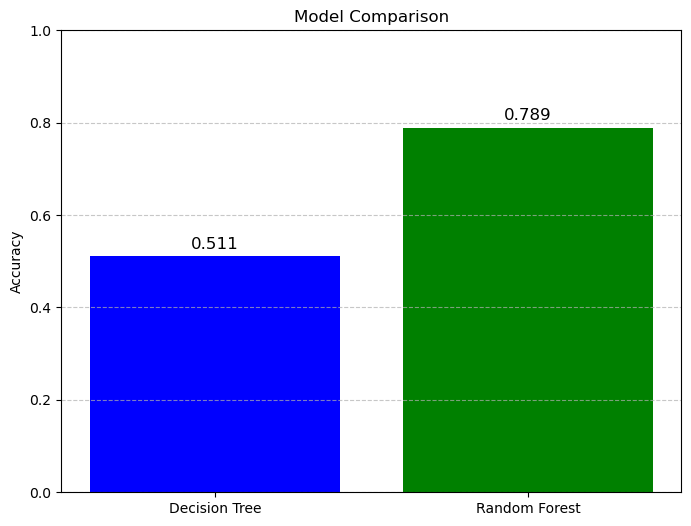

In [28]:
# Plot comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(["Decision Tree", "Random Forest"], [accuracy_dt, accuracy_rf], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=12)

plt.show()
